In [1]:
import json

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
from geopy.distance import geodesic
from scipy.ndimage import gaussian_filter1d
from scipy.signal import find_peaks
from shapely.geometry import LineString, Point

from railroad import (CustomJSONEncoder, custom_json_decoder, load_graph,
                      plot_node_graph, save_graph, test_road_graph)
from utils import osmnx_to_geopandas, print_graph_info, compute_length

In [2]:
with open("../data/standard_variables.json", "r") as f:
    standard_variables_data = json.load(f)


xlim = (standard_variables_data['map_limits']['west'],
        standard_variables_data['map_limits']['east'])
ylim = (standard_variables_data['map_limits']['south'],
        standard_variables_data['map_limits']['north'])
print(xlim, ylim)

standard_variables_data

(-22.083955, -21.640345) (64.033992, 64.188968)


{'map_limits': {'north': 64.188968,
  'south': 64.033992,
  'east': -21.640345,
  'west': -22.083955},
 'grid_size': {'unit': 'meters', 'value': 100},
 'standard_variables': {'cutoff_radius': {'unit': 'meters', 'value': 400}}}

In [3]:
G = load_graph('../data/simplified_railroads.json')
print_graph_info(G)
test_road_graph(G)

Undirected has 58 nodes and 63 edges
+----------------------+
Nodes
+----------------------+
*** Node: 1848219055 ***
  Data: {'street_count': 3, 'geometry': <POINT (-21.81 64.086)>, 'year': 2025, 'is_station': True}
*** Node: 602729079 ***
  Data: {'street_count': 3, 'geometry': <POINT (-21.844 64.09)>, 'year': 2025, 'is_station': True}
*** Node: 111465687 ***
  Data: {'street_count': 3, 'geometry': <POINT (-21.872 64.099)>, 'year': 2025, 'is_station': True}
*** Node: 2320789566 ***
  Data: {'street_count': 3, 'geometry': <POINT (-21.88 64.102)>, 'year': 2025}
*** Node: 2320771865 ***
  Data: {'street_count': 3, 'geometry': <POINT (-21.882 64.102)>, 'year': 2025, 'is_station': True}
*** Node: 2328470640 ***
  Data: {'street_count': 3, 'geometry': <POINT (-21.887 64.11)>, 'year': 2025, 'is_station': True}
+----------------------+
Edges
+----------------------+
*** Edge: 1848219055 -> 602729079 ***
  Data: {'name': 'Arnarnesvegur-Salavegur-Kóratorg-Rjúpnavegur-Arnarnesvegur-Rjúpnavegur-

In [4]:
G.edges[35786587, 1232404889]['year']

2029

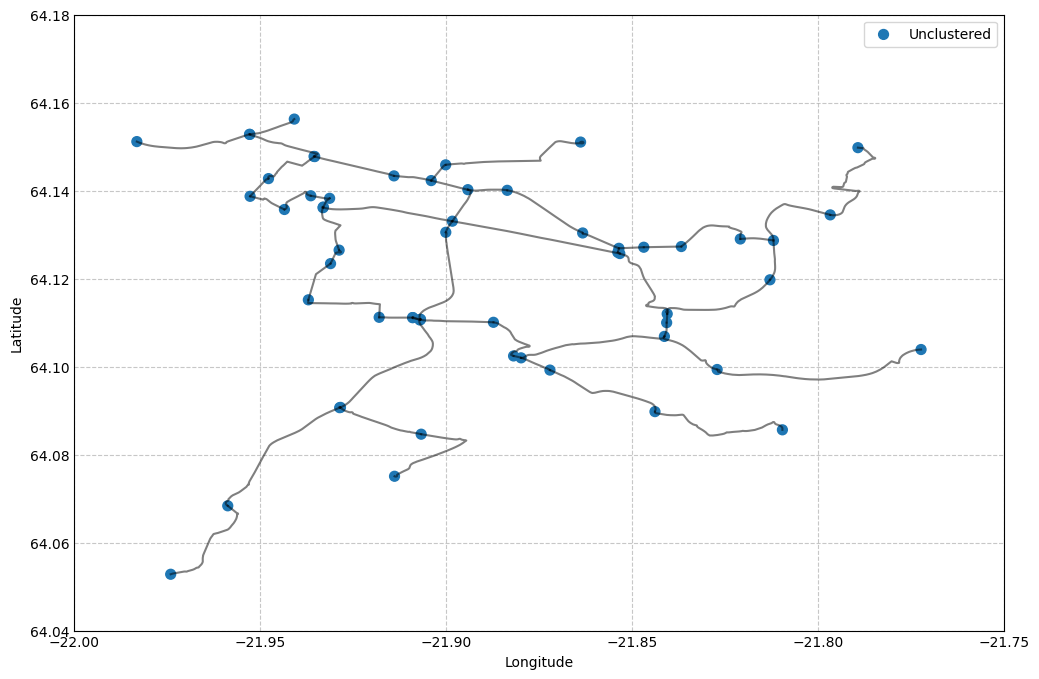

(<Figure size 1200x800 with 1 Axes>,
 <Axes: xlabel='Longitude', ylabel='Latitude'>)

In [5]:
plot_node_graph(G)

In [6]:
with open('../data/new_stops.json', 'r') as file:
    new_stops = json.load(file, object_hook=custom_json_decoder)
print(new_stops)

{(1848219055, 602729079): [(1.850000000000001, 4.266348565285389), (2.7499999999999982, 1.26068753955372)], (602729079, 111465687): [(0.8000000000000002, 2.3444762741659595)], (2320789566, 1201238829): [(1.2000000000000004, 6.9928352943929175), (2.3499999999999996, 1.6483585180462348)], (2328470640, 1889922204): [(1.1000000000000003, 2.736809196925158)], (1896201758, 35786592): [(1.800000000000001, 1.207145164900105)], (534441279, 11142383860): [(1.3500000000000005, 1.3671054248073542)], (633181059, 35786587): [(1.900000000000001, 3.4012482340598784), (2.849999999999998, 8.432543029474356)], (1014753490, 12339218093): [(1.5500000000000007, 15.13174583834774)], (1225420655, 470330429): [(0.9000000000000002, 17.17013752852332)], (5902567606, 1229320617): [(1.5000000000000007, 2.7639999862128857)], (35786587, 27237169): [(2.1000000000000005, 25.325420148185803), (3.7999999999999945, 1.0057395968858607)], (1208295444, 59981798): [(1.7000000000000008, 1.229321168687108)], (59981798, 1206684

In [7]:
def split_linestring_by_points(line, lengths):
    """
    Splits a LineString into segments based on a sorted list of cumulative lengths.

    Parameters:
        line (LineString): The input LineString to be split.
        lengths (list): A sorted list of cumulative lengths where the LineString should be split.

    Returns:
        list[LineString]: A list of LineString segments.
    """
    # Ensure the input is valid
    assert isinstance(line, LineString), "Input must be a LineString."
    assert all(isinstance(length, (int, float))
               for length in lengths), "All lengths must be numbers."
    assert sorted(lengths) == lengths, "The lengths must be sorted."
    assert max(
        lengths) <= line.length, "The maximum length cannot exceed the LineString's total length."

    segments = []
    # Initialize with the starting point of the LineString
    segment_coords = [line.coords[0]]
    total_length = 0
    length_index = 0

    # Iterate over linear segments of the LineString
    for start, end in zip(line.coords[:-1], line.coords[1:]):
        start_point = Point(start)
        end_point = Point(end)
        segment_length = start_point.distance(end_point)

        # If adding this segment exceeds the current target length
        while length_index < len(lengths) and total_length + segment_length > lengths[length_index]:
            remaining_length = lengths[length_index] - total_length
            # Interpolate the splitting point
            interpolation_factor = remaining_length / segment_length
            split_point = Point([
                start[0] + interpolation_factor * (end[0] - start[0]),
                start[1] + interpolation_factor * (end[1] - start[1])
            ])
            segment_coords.append(split_point.coords[0])
            # Add the completed segment if it has at least two points
            if len(segment_coords) > 1:
                segments.append(LineString(segment_coords))
            # Prepare for the next segment
            segment_coords = [split_point.coords[0]]
            total_length = lengths[length_index]
            length_index += 1

        # Add the current segment to the list if no split is required
        segment_coords.append(end_point.coords[0])
        total_length += segment_length

    # Add any remaining coordinates to the final segment
    if len(segment_coords) > 1:
        segments.append(LineString(segment_coords))

    return segments

In [8]:
def split_edge(G, edge, segment_length):
    """
    Splits an edge in graph G at specified positions.

    Parameters:
    - G: undirected graph
    - edge: tuple (node1, node2) specifying the edge
    - positions: list of positions (fractions of the edge length) to split at
    """
    # Extract edge data
    u, v = edge

    edge_data = G.edges[edge]
    year = edge_data['year']
    name = edge_data['name']

    line = edge_data['geometry']  # Assuming this is a LineString

    origin_node = edge_data['origin_node']
    if v == origin_node:
        final_node = u
    elif u == origin_node:
        final_node = v
    else:
        raise 'Incorrect node'

    original_length = compute_length(line)

    original_segment_length = np.diff([0] + segment_length + [original_length])

    # Normalize positions to fractions of the line length
    scale = line.length / original_length
    internal_length = sorted(
        [scale * length for length in segment_length])

    segments = split_linestring_by_points(line, internal_length)

    # Compute segment lengths
    segment_lengths = [seg.length for seg in segments]

    # Length consistency check
    print(f'{original_length = }, {line.length = }, {sum(segment_lengths) = }')
    if not np.isclose(sum(segment_lengths), line.length, atol=1e-6):
        print("Warning: Sum of segment lengths does not match original line length!")

    # Update the graph: Create nodes first
    G.remove_edge(u, v)  # Remove the original edge
    node_ids = [origin_node]  # Start with the original start node

    # Create new nodes for the split points
    max_id = max(list(G.nodes)) + 1
    # All intermediate segments need new nodes
    for i, geom in enumerate(segments[:-1]):
        new_node = max_id
        max_id += 1
        node_ids.append(new_node)
        G.add_node(new_node, geometry=Point(
            geom.coords[-1]), year=year, is_autogenerated_stop=True)

    updated_length = [compute_length(seg) for seg in segments]

    print(f'{original_segment_length = }\n{updated_length = }')
    # assert np.allclose(original_segment_length, updated_length,
    #                    atol=1e-2), "Lengths do not match!"

    # Update the graph: Create edges between nodes
    for i in range(len(node_ids)):
        G.add_edge(node_ids[i], node_ids[i + 1] if i < len(segments) - 1 else final_node,
                   name=name,
                   year=year,
                   length=updated_length[i],
                   geometry=segments[i],
                   origin_node=node_ids[i])

In [9]:
for edge, stop_data in new_stops.items():
    if edge in G.edges:
        segment_length = [d[0] for d in stop_data]
        if segment_length:
            split_edge(G, edge, segment_length)
        else:
            raise f'Segment of length {segment_length} in edge {edge}'
    else:
        print('edge not found:', edge)

original_length = 4.118939154012401, line.length = 0.03753906857023466, sum(segment_lengths) = 0.037539068570234646
original_segment_length = array([1.85      , 0.9       , 1.36893915])
updated_length = [1.852233932766105, 0.8808852839663808, 1.385819937278408]
original_length = 3.428397646060108, line.length = 0.031257543966392395, sum(segment_lengths) = 0.031257543966392395
original_segment_length = array([0.8       , 2.62839765])
updated_length = [0.7936602302145612, 2.6347374158457146]
original_length = 4.342773146001949, line.length = 0.03931638159222609, sum(segment_lengths) = 0.0393163815922261
original_segment_length = array([1.2       , 1.15      , 1.99277315])
updated_length = [1.1975829299714886, 1.121476724934384, 2.023713491096207]
original_length = 2.1746604656566757, line.length = 0.01964416814485208, sum(segment_lengths) = 0.019644168144852075
original_segment_length = array([1.1       , 1.07466047])
updated_length = [1.1002210244419934, 1.0744394412147553]
original_len

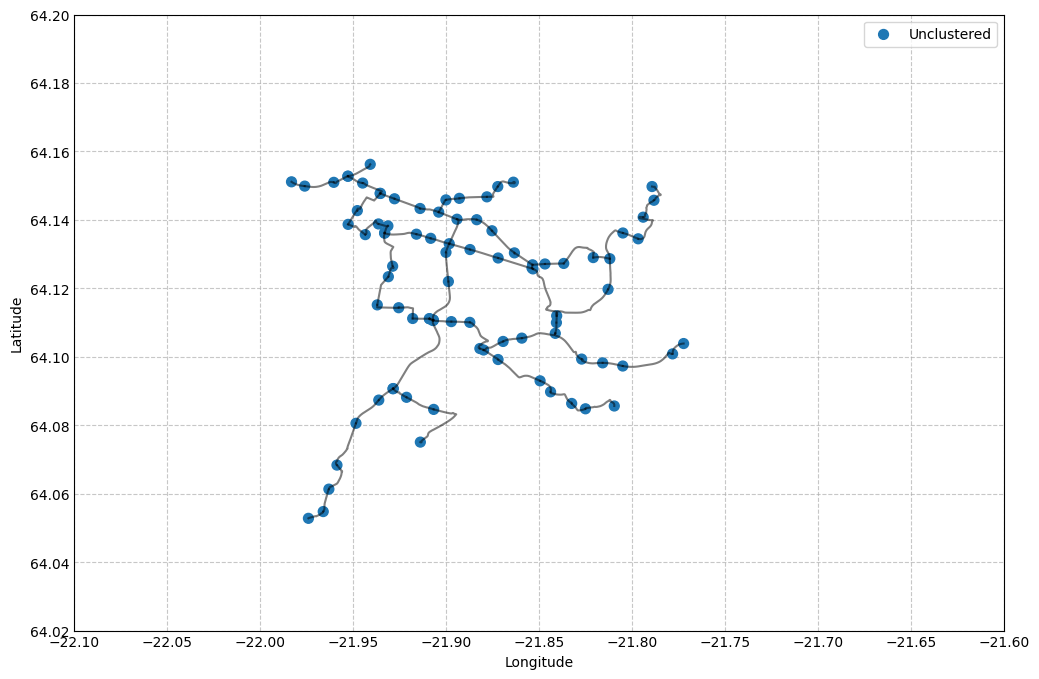

(<Figure size 1200x800 with 1 Axes>,
 <Axes: xlabel='Longitude', ylabel='Latitude'>)

In [10]:
plot_node_graph(G, draw_edges=True, xlim=xlim, ylim=ylim, add_map=False)

In [11]:
for node, data in G.nodes(data=True):
    if (not data.get('is_autogenerated_stop', False)) and (not data.get('is_station', False)):
        continue
    data['if_final_stop_of_any_kind'] = True

In [12]:
print_graph_info(G)

Undirected has 89 nodes and 94 edges
+----------------------+
Nodes
+----------------------+
*** Node: 1848219055 ***
  Data: {'street_count': 3, 'geometry': <POINT (-21.81 64.086)>, 'year': 2025, 'is_station': True, 'if_final_stop_of_any_kind': True}
*** Node: 602729079 ***
  Data: {'street_count': 3, 'geometry': <POINT (-21.844 64.09)>, 'year': 2025, 'is_station': True, 'if_final_stop_of_any_kind': True}
*** Node: 111465687 ***
  Data: {'street_count': 3, 'geometry': <POINT (-21.872 64.099)>, 'year': 2025, 'is_station': True, 'if_final_stop_of_any_kind': True}
*** Node: 2320789566 ***
  Data: {'street_count': 3, 'geometry': <POINT (-21.88 64.102)>, 'year': 2025}
*** Node: 2320771865 ***
  Data: {'street_count': 3, 'geometry': <POINT (-21.882 64.102)>, 'year': 2025, 'is_station': True, 'if_final_stop_of_any_kind': True}
*** Node: 2328470640 ***
  Data: {'street_count': 3, 'geometry': <POINT (-21.887 64.11)>, 'year': 2025, 'is_station': True, 'if_final_stop_of_any_kind': True}
+-------

In [13]:
for id_in, id_out, data in G.edges(data=True):
    origin_id = data['origin_node']
    assert origin_id in (id_in, id_out)
    if not np.all(np.equal(G.nodes[origin_id]['geometry'].coords, data['geometry'].coords[0])):
        print(
            f"{np.equal(G.nodes[origin_id]['geometry'].coords , data['geometry'].coords[0]) = }")
        print(
            f"{G.nodes[origin_id]['geometry'].coords[0]} != {data['geometry'].coords[0]}")

In [14]:
nodes_gdf, edges_gdf = osmnx_to_geopandas(G)
edges_gdf.to_file("../data/final_railroads.geojson", driver="GeoJSON")
nodes_gdf.to_file("../data/final_railroads_nodes.geojson", driver="GeoJSON")

In [15]:
for id_in, id_out, data in G.edges(data=True):
    line = data['geometry']
    from_point = G.nodes[id_in]['geometry']
    to_point = G.nodes[id_out]['geometry']

    # Define line_start and line_end for clarity and reuse
    line_start = Point(line.coords[0])
    line_end = Point(line.coords[-1])

    distance_between_stations = geodesic(
        (from_point.x, from_point.y), (to_point.x, to_point.y)).meters
    distance_in_start = geodesic(
        (line_start.x, line_start.y), (from_point.x, from_point.y)).meters
    distance_in_end = geodesic(
        (line_end.x, line_end.y), (from_point.x, from_point.y)).meters
    distance_out_start = geodesic(
        (line_start.x, line_start.y), (to_point.x, to_point.y)).meters
    distance_out_end = geodesic(
        (line_end.x, line_end.y), (to_point.x, to_point.y)).meters

    if distance_in_start == 0 and distance_out_end == 0:
        # Edge is correct
        continue
    elif distance_in_end == 0 and distance_out_start == 0:
        # Edge is inverted but correct
        continue
    else:
        print('Edge is incorrect')
        print(f'Edge {id_in} -> {id_out}')
        print(f'{from_point.x, from_point.y = }')
        print(f'{to_point.x, to_point.y = }')
        print(f'{line_start.x, line_start.y = }')
        print(f'{line_end.x, line_end.y = }')
        print(f'Distance between stations: {distance_between_stations:.2f} m')
        print(f'Distance from in to start: {distance_in_start:.2f} m')
        print(f'Distance from in to end: {distance_in_end:.2f} m')
        print(f'Distance from out to start: {distance_out_start:.2f} m')
        print(f'Distance from out to end: {distance_out_end:.2f} m')

        if distance_in_start < 1 and distance_out_end < 1:
            print('Fixing edge geometry: updating start and end points to match nodes.')
            data['geometry'] = LineString(
                [(from_point.x, from_point.y), (to_point.x, to_point.y)])
        elif distance_in_end < 1 and distance_out_start < 1:
            print(
                'Fixing edge geometry: updating inverted start and end points to match nodes.')
            data['geometry'] = LineString(
                [(to_point.x, to_point.y), (from_point.x, from_point.y)])
        else:
            raise ValueError(
                f'Edge {id_in} -> {id_out} has discrepancies above 1 meter and cannot be fixed.')

In [16]:
test_road_graph(G)

In [17]:
save_graph(G, '../data/final_railroads.json')